# Analysing Taylor Swift Lyrics with Python

**Analysing Taylor Swift Lyrics with sentiment analysis**

In this project, I will explore her references to ‘midnight’ leading up to this point, then i’ll expand your search to track her references to day, night, and time in general. Then I will use sentiment analysis to study her tone and vibe over the course of her career. Then I’ll put it all together to determine if she writes more favorably about day or night. 

## Imports

In [94]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
import chardet
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

In [95]:
nltk.download('stopwords') # Run this if you get an error when running clean_lyrics().
nltk.download('punkt') # Run this if you get an error when tokenising.
nltk.download('vader_lexicon') # Run this if you get an error when analysing lyric sentiment.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simritibundhoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simritibundhoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simritibundhoo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load and Inspect Data

### Loading the Dataset

In [96]:
# Use the chardet library to automatically detect the encoding of the file
with open("taylor_swift_lyrics.csv", 'rb') as f:
    result = chardet.detect(f.read())

# Load dataset
lyrics = pd.read_csv("taylor_swift_lyrics.csv", encoding=result['encoding'])

# Inspect first few rows
lyrics.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


### Clean the lyric text

In [97]:
stop_words = set(stopwords.words('english'))

def clean_lyrics(text):
    # Convert to lowercase using Pandas str.lower()
    text = text.str.lower()
    
    # Remove punctuation using regex [^\w\s]
    text = text.str.replace('[^\w\s]', '')
    
    # Remove stop words
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return text

# Apply the clean_lyrics function to the 'lyric' column
lyrics['clean_lyric'] = clean_lyrics(lyrics['lyric'])

# View the first few rows to check the result
print(lyrics[['lyric', 'clean_lyric']].head())

                                         lyric                    clean_lyric
0          He said the way my blue eyes shined      said way blue eyes shined
1  Put those Georgia stars to shame that night  put georgia stars shame night
2                       I said, "That's a lie"             said, "that's lie"
3                  Just a boy in a Chevy truck                boy chevy truck
4         That had a tendency of gettin' stuck         tendency gettin' stuck


### Find Keywords

We will first count how many times midnight occurs in Taylor Swift’s lyrics.

In [98]:
# Create a new column indicating if a lyric has "midnight" in it
lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight', case=False)

'''
case=False: This parameter is optional. Setting case=False makes 
the search case-insensitive. So, it will match occurrences of 
"midnight" regardless of whether they are in uppercase or lowercase.
'''

# Check how many times "midnight" occurs
midnight_count = lyrics['midnight'].sum()

# Display the count
print("Number of occurrences of 'midnight':", midnight_count)

Number of occurrences of 'midnight': 6


### Expanding the keywords list

In [99]:
# Night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

In [100]:
# Join the lists into a regular expression string using | to indicate "or"
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

# Create new columns for each word category
lyrics['night_words'] = lyrics['clean_lyric'].str.contains(night_regex, case=False)
lyrics['day_words'] = lyrics['clean_lyric'].str.contains(day_regex, case=False)
lyrics['time_words'] = lyrics['clean_lyric'].str.contains(time_regex, case=False)

# Count how many times the words appeared
night_word_count = lyrics['night_words'].sum()
day_word_count = lyrics['day_words'].sum()
time_word_count = lyrics['time_words'].sum()

# Print the result
print(f'Night word count: {night_word_count}')
print(f'Day word count: {day_word_count}')
print(f'Time word count: {time_word_count}')

# Inspect the first few rows of the lyrics DataFrame
print(lyrics[['clean_lyric', 'night_words', 'day_words', 'time_words']].head())

Night word count: 160
Day word count: 208
Time word count: 16
                     clean_lyric  night_words  day_words  time_words
0      said way blue eyes shined        False      False       False
1  put georgia stars shame night         True      False       False
2             said, "that's lie"        False      False       False
3                boy chevy truck        False      False       False
4         tendency gettin' stuck        False      False       False


## Visualise and Investigate the Data

### Visualise how Taylor Swift’s mentions of time have changed over time

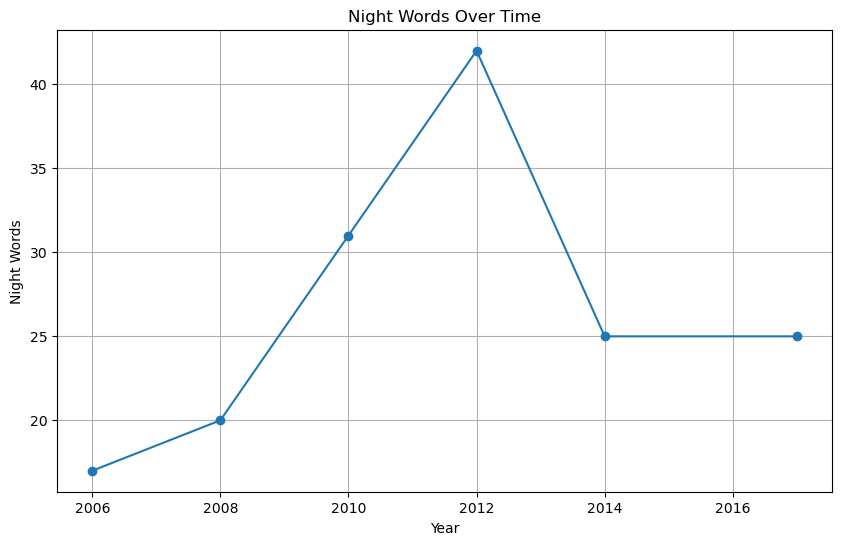

In [101]:
# Create a new DataFrame with yearly mentions
yearly_mentions = lyrics.groupby('year').sum()

# Reset the index to make it easier to use with matplotlib
yearly_mentions.reset_index(inplace=True)

# Create a line chart showing the night mentions over time
plt.figure(figsize=(10, 6))
plt.plot(yearly_mentions['year'], yearly_mentions['night_words'], marker='o', linestyle='-')
plt.title('Night Words Over Time')
plt.xlabel('Year')
plt.ylabel('Night Words')
plt.grid(True)
plt.show()

### What albums are the most night/day focused?

In [102]:
# Find the year with the most night mentions
night_most_mentions = yearly_mentions.nlargest(1, 'night_words')['year'].values[0]
print(f"Year with the most night mentions: {night_most_mentions}")

# Find the year with the least night mentions
least_night_year = yearly_mentions.nsmallest(1, 'night_words')['year'].values[0]
print(f"Year with the least night mentions: {least_night_year}")

#Find the year with the most day mentions
day_most_mentions =yearly_mentions.nlargest(1, 'day_words')['year'].values[0]
print(f"Year with the most day mentions: {day_most_mentions}")

# Find the year with the least day mentions
least_day_year = yearly_mentions.nsmallest(1, 'day_words')['year'].values[0]
print(f"Year with the least day mentions: {least_day_year}")

Year with the most night mentions: 2012
Year with the least night mentions: 2006
Year with the most day mentions: 2010
Year with the least day mentions: 2008


### Compare day to night mentions

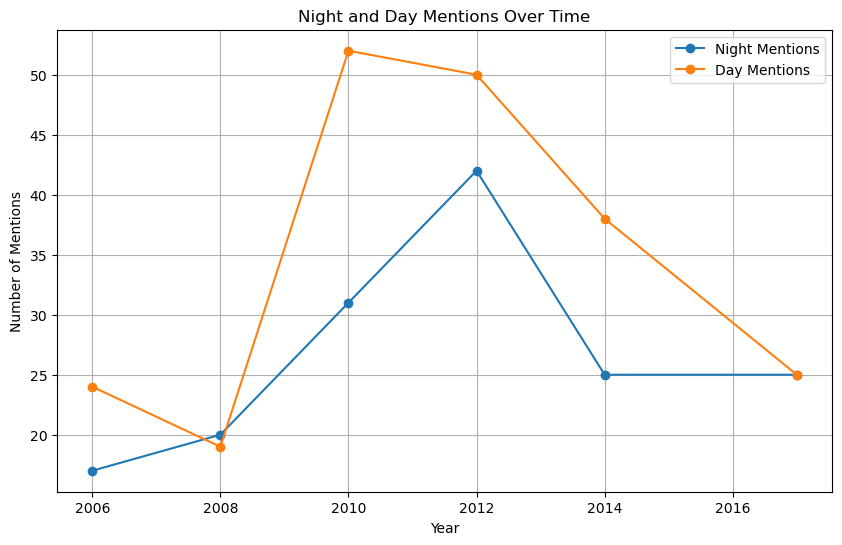

In [103]:
# Create a line chart with both night and day mentions
plt.figure(figsize=(10, 6))
plt.plot(yearly_mentions['year'], yearly_mentions['night_words'], marker='o', linestyle='-', label='Night Mentions')
plt.plot(yearly_mentions['year'], yearly_mentions['day_words'], marker='o', linestyle='-', label='Day Mentions')

# Set labels and title
plt.title('Night and Day Mentions Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Mentions')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### Investigating position of day vs. night mentions within albums

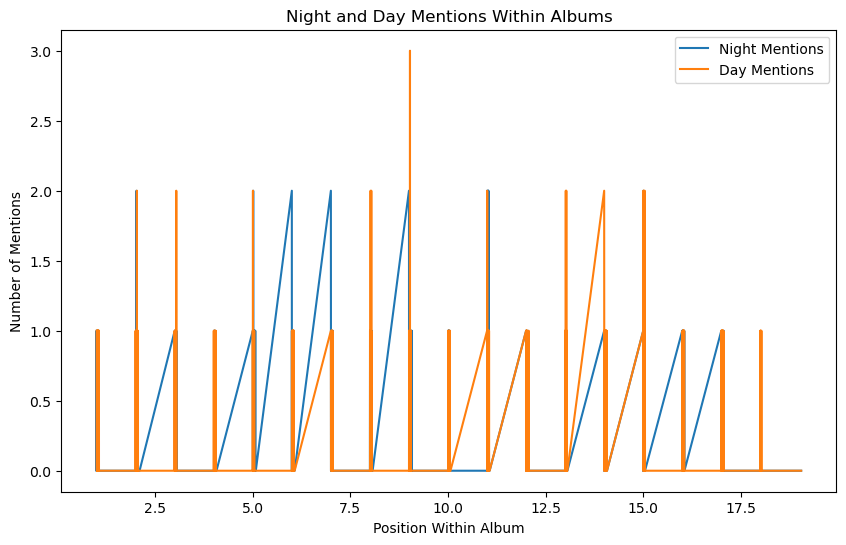

In [104]:
# Create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + (lyrics['line']/1000)

# Create a new DataFrame called positional_mentions
positional_mentions = lyrics.groupby('position').sum().reset_index()

# Create a line chart showing the night and day mentions as a position within the album
plt.figure(figsize=(10, 6))
plt.plot(positional_mentions['position'], positional_mentions['night_words'], label='Night Mentions', linestyle='-')
plt.plot(positional_mentions['position'], positional_mentions['day_words'], label='Day Mentions', linestyle='-')
plt.title('Night and Day Mentions Within Albums')
plt.xlabel('Position Within Album')
plt.ylabel('Number of Mentions')
plt.legend()
plt.show()

## Sentiment Analysis

### Tokenise the lyrics

In [105]:
# Tokenize the cleaned lyrics
lyrics['lyrics_tok'] = lyrics['clean_lyric'].apply(lambda x: word_tokenize(x))

# Create a list of all the tokens in the lyrics_tok column into one list
all_tokens = [token for sublist in lyrics['lyrics_tok'] for token in sublist]

# Use the Counter function to count the number of times each word appears
word_counts = Counter(all_tokens)

# Sort the resulting dictionary
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted word counts
print(sorted_word_counts)

{',': 2051, 'i': 572, '?': 288, 'know': 286, 'like': 285, "'m": 278, "'s": 251, '(': 240, ')': 234, 'oh': 206, 'back': 202, 'never': 192, 'time': 163, 'love': 159, 'na': 149, 'got': 148, "n't": 145, "'ll": 141, "'cause": 132, 'say': 131, 'we': 124, 'baby': 120, 'one': 117, "'": 116, 'see': 116, 'want': 112, 'think': 109, 'could': 108, 'go': 107, 'ever': 103, 'said': 100, 'ca': 100, 'look': 98, "'ve": 96, 'would': 95, 'me': 90, 'come': 89, 'stay': 88, 'that': 86, 'take': 86, 'made': 85, 'you': 84, '!': 84, 'wan': 82, "'d": 81, 'shake': 80, "'re": 78, '``': 77, 'yeah': 76, "''": 75, 'night': 72, 'let': 72, 'ey': 72, 'way': 71, 'tell': 71, 'wish': 71, 'right': 69, 'good': 69, 'yet': 68, 'first': 66, 'get': 66, 'girl': 66, 'it': 66, 'gon': 65, 'last': 65, 'feel': 64, 'bad': 63, 'better': 60, 'home': 60, 'call': 60, 'new': 59, 'everything': 57, 'away': 57, 'things': 53, 'eyes': 52, 'around': 51, 'dancing': 51, 'long': 50, 'nothing': 50, 'break': 49, 'still': 49, 'knew': 49, 'make': 48, 'gon

### Analyse Lyric Sentiment

In [106]:
# Run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [107]:
# Create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))

# Transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

# Inspect the first few rows
lyrics.head()

,artist,album,track_title,track_n,lyric,line,year,clean_lyric,midnight,night_words,day_words,time_words,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006,said way blue eyes shined,False,False,False,False,1.001,"[said, way, blue, eyes, shined]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006,put georgia stars shame night,False,True,False,False,1.002,"[put, georgia, stars, shame, night]","{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'comp...",0.437,0.563,0.0,-0.4767
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006,"said, ""that's lie""",False,False,False,False,1.003,"[said, ,, ``, that, 's, lie, '']","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006,boy chevy truck,False,False,False,False,1.004,"[boy, chevy, truck]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006,tendency gettin' stuck,False,False,False,False,1.005,"[tendency, gettin, ', stuck]","{'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound...",0.500,0.500,0.0,-0.2500


### Corpus Sentiment Analysis

Overall Sentiment:
pos         882.1310
neg         466.6160
compound    341.4484
dtype: float64


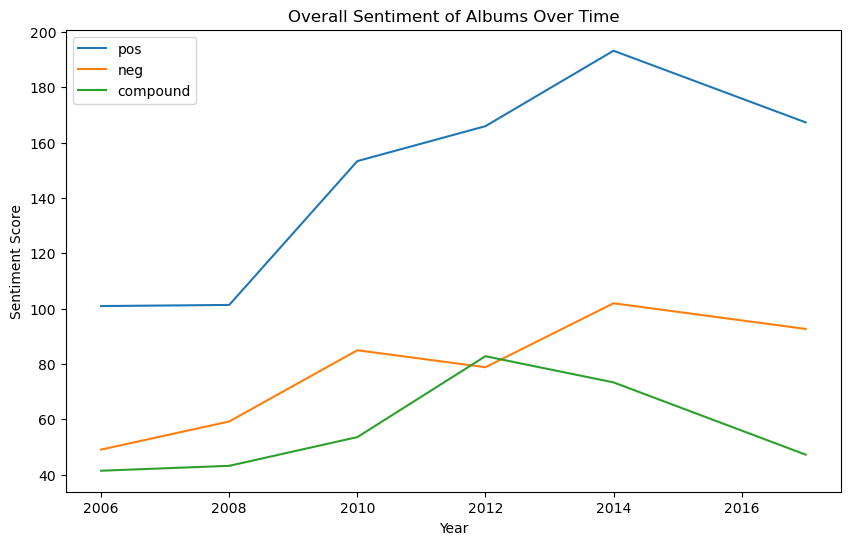

In [117]:
# Calculate overall sentiment for the entire collection
overall_sentiment = lyrics[['pos', 'neg', 'compound']].sum()
print("Overall Sentiment:")
print(overall_sentiment)

# Visualize overall sentiment of her albums over time
album_sentiment_over_time = lyrics.groupby('year')[['pos', 'neg', 'compound']].sum()
album_sentiment_over_time.plot(figsize=(10, 6), title='Overall Sentiment of Albums Over Time')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.show()

### Day or Night? Positive or Negative?

In [119]:
# Create DataFrames for night and day lyrics
night_lyrics = lyrics[lyrics['night_words']]
day_lyrics = lyrics[lyrics['day_words']]

# Check the number of values in each DataFrame
print("Number of night lyrics:", len(night_lyrics))
print("Number of day lyrics:", len(day_lyrics))

# Calculate sentiment for night lyrics
night_pos = night_lyrics['pos'].sum()
night_neg = night_lyrics['neg'].sum()
night_compound = night_lyrics['compound'].sum()

# Calculate sentiment for day lyrics
day_pos = day_lyrics['pos'].sum()
day_neg = day_lyrics['neg'].sum()
day_compound = day_lyrics['compound'].sum()

# Print sentiment for night and day
print("\nSentiment for Night Lyrics:")
print("Positive:", night_pos)
print("Negative:", night_neg)
print("Compound:", night_compound)

print("\nSentiment for Day Lyrics:")
print("Positive:", day_pos)
print("Negative:", day_neg)
print("Compound:", day_compound)


Number of night lyrics: 160
Number of day lyrics: 208

Sentiment for Night Lyrics:
Positive: 30.687999999999995
Negative: 9.82
Compound: 18.034100000000002

Sentiment for Day Lyrics:
Positive: 33.989999999999995
Negative: 10.565
Compound: 22.093
